<a href="https://colab.research.google.com/github/aniketjivani/WLROM/blob/main/21_process_2161_summary_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pre-process 2161 White Light Images, and parameter features to predict summaries for $U$, $N$ and $B$. Reload experiment 97258 for first set of results.

Next set of experiments compares augmentation (expt 14693) vs non-augmentation of parameters (99514)

Final set passes in raw observation data / median smoothed observation data through the trained network and observes the output.

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install --quiet rich
!pip install --quiet "sunpy[visualization]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 40.8 MB/s eta 0:00:00


In [4]:
import sys
import torch
import torch.nn
import torch.nn as nn
from torch.nn.functional import relu
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.utils.data import random_split
import pandas as pd
import numpy as np
import os
import re
import sys
import logging
import torchvision
import torchvision.transforms as T

In [5]:
args = {
    "niters": 450,
    "lr": 0.001,
    "save": "arr_experiments/",
    "load": 99514,
    "r": 1991,
    "resize_dims": (16, 64),
    "param_scaling": [1, 1],
    "warm_start": 20376,
    "do_warm_start": False,
    # "loss": "smooth_l1",
    "loss": "mae",
    # "loss": "mse",
    "batch_size": 64,
    "dropout":False
}

In [6]:
import torch.nn as nn

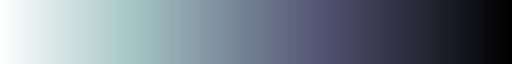

In [7]:
from sunpy.visualization import colormaps as cm

lc3_reg = cm.cmlist['soholasco3']
lc3_reg

lc3 = cm.cmlist['soholasco3'].reversed()
lc3

In [8]:
import time
import datetime
import argparse
from random import SystemRandom

from rich.progress import track
import tqdm

import matplotlib.pyplot as plt

import sys
sys.path.append('/content/drive/MyDrive/WLROM/')

import cnn_utils as cu

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [12]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

Load params and filter out runs by Sim ID Correctly

In [13]:
import os
os.getcwd()

'/content'

In [14]:
cme_params_scaled = pd.read_csv("./drive/MyDrive/WLROM/old_data_surrogate/CMEParams2161_Scaled.csv")
# cme_params_scaled.head()

# rename unnamed column to SimID
cme_params_scaled = cme_params_scaled.rename(columns={'Unnamed: 0': 'SimID'})
# cme_params_scaled = cme_params_scaled.loc[:, ~cme_params_scaled.columns.str.contains('^Unnamed')]
cme_params_scaled.head()

,SimID,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506


In [15]:
cme_params_scaled.tail()

,SimID,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
273,294,0.875,0.252834,0.622193,0.175,0.0,0.363636,0.352593,0.005643,0.937194
274,295,0.125,0.655648,0.235434,0.475,0.0,0.363636,0.352593,0.005643,0.937194
275,296,0.325,0.518360,0.245710,0.775,1.0,0.363636,0.352593,0.005643,0.937194
276,297,0.925,0.289994,0.829820,0.675,0.0,0.363636,0.352593,0.005643,0.937194
277,298,0.625,0.406615,0.394121,0.375,1.0,0.363636,0.352593,0.005643,0.937194


In [16]:
cme_params_scaled.index

RangeIndex(start=0, stop=278, step=1)

In [17]:
# Load IDs to keep amongst successful runs (1-indexed!)
ids_to_keep_raw = np.load("./drive/MyDrive/WLROM/old_data_surrogate/ids_to_keep_2161.npy")
ids_to_keep = ids_to_keep_raw - 1
ids_to_keep.shape

(254,)

In [18]:
ids_to_keep

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  60,  61,  63,  64,  65,  66,  67,  68,
        69,  71,  72,  73,  74,  75,  76,  77,  79,  80,  81,  87,  88,
        89,  90,  91,  92,  93,  95,  97,  98,  99, 101, 102, 103, 104,
       105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132,
       133, 135, 138, 140, 141, 143, 144, 145, 147, 148, 149, 152, 153,
       154, 155, 157, 159, 160, 161, 162, 163, 165, 166, 167, 168, 170,
       171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182, 183, 184,
       185, 186, 187, 188, 189, 191, 192, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 21

In [19]:
successful_sim_ids = cme_params_scaled['SimID'].to_numpy()
successful_sim_ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  79,
        80,  81,  82,  83,  84,  87,  88,  89,  90,  91,  92,  93,  95,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 137,
       138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152,
       153, 154, 155, 157, 159, 160, 161, 162, 163, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 19

In [20]:
# find indices of successful sim IDs to keep
indices_to_keep = np.where(np.isin(successful_sim_ids, ids_to_keep))[0]
indices_to_keep.shape

(254,)

In [21]:
# np.linspace(0, 277, 278, dtype=int)[ids_to_keep]

In [22]:
filtered_df = cme_params_scaled[cme_params_scaled['SimID'].isin(ids_to_keep)]
filtered_df.head()

,SimID,Radius,BStrength,ApexHeight,OrientationCme,iHelicity,realization,FactorB0,PoyntingFluxPerBSi,LperpTimesSqrtBSi
0,0,0.5675,0.420040,0.568916,0.5525,1.0,0.272727,0.120833,0.098542,0.436506
1,1,0.4525,0.057350,0.348039,0.1025,1.0,0.272727,0.120833,0.098542,0.436506
2,2,0.8525,0.014777,0.541725,0.8775,1.0,0.272727,0.120833,0.098542,0.436506
3,3,0.1225,0.323231,0.214567,0.5075,0.0,0.272727,0.120833,0.098542,0.436506
4,4,0.7825,0.085414,0.640815,0.3325,1.0,0.272727,0.120833,0.098542,0.436506


In [23]:
filtered_df.shape

(254, 10)

In [24]:
# remove simID column and convert to numpy
cme_params_np = filtered_df.iloc[:, 1:].to_numpy()
cme_params_np.shape

(254, 9)

Similarly load raw data and filter out runs by SimID correctly.

In [25]:
raw_images = np.load("./drive/MyDrive/WLROM/old_data_surrogate/CR2161_tDecay2h_Polar_Compressed.npy")

In [26]:
raw_images.shape

(64, 256, 90, 278)

In [27]:
raw_images_to_keep = raw_images[:62, :, :, indices_to_keep]
raw_images_to_keep.shape

(62, 256, 90, 254)

In [28]:
raw_min, raw_max = raw_images_to_keep.min(), raw_images_to_keep.max()
raw_min, raw_max

(0.9140037834350702, 1.5)

Load summary stats and process

In [29]:
summary_stats_raw = pd.read_csv("./drive/MyDrive/WLROM/old_data_surrogate/SummaryStats_2161Old.csv")
summary_stats_raw.head(), summary_stats_raw.shape

(   SIMID       summU      summN      summB  summArr
 0     31  753.379514  14.740539   5.474132     30.0
 1     32  543.552620  15.089102   8.494696     57.0
 2     33  619.406555  13.467365   8.892779     62.0
 3     34  467.688730  12.598024   6.808105     58.0
 4     35  651.469120  26.994850  11.082531     49.0,
 (254, 5))

In [30]:
# convert last 4 cols of summary stats to numpy
summary_stats_np = summary_stats_raw.iloc[:, 1:].to_numpy()
summary_stats_np.shape

(254, 4)

In [31]:
num_sim = len(indices_to_keep)
num_sim

254

In [32]:
data_sim_ids = np.linspace(0, num_sim - 1, num_sim, dtype=int)

In [33]:
generator1 = torch.Generator().manual_seed(2024)
train_frac, val_frac, test_frac = 0.7, 0.1, 0.2
train_valid_test = random_split(data_sim_ids,
                                [train_frac, val_frac, test_frac],
                                # [train_size, valid_size, test_size],
                                generator=generator1)

In [34]:
train_idx = np.array(train_valid_test[0].indices)
val_idx = np.array(train_valid_test[1].indices)
test_idx = np.array(train_valid_test[2].indices)

In [35]:
train_idx

array([162, 142, 138,  96,  27,  94, 244, 124,  61,  18,  55, 210, 161,
        10, 224,  32, 231, 238,   4, 249, 181, 111, 240,   0,  43,  17,
       241, 134, 233, 235, 212, 169, 173, 242,   3,   7,  30,  23, 117,
       229,  80, 188,  84, 100, 133, 214,  29,  35,  56, 196, 243, 199,
       118, 218, 226,   8, 198,  46, 211, 221,   2,  31, 110,  87,  83,
        72,  63, 227, 147, 216,  97, 250, 203, 253, 180, 148,  95, 225,
       205, 160, 239,  13,  71, 179, 223, 154,  36,  20, 146, 143,  76,
       247, 177,   9, 127, 167, 245, 114, 158, 168,  78, 176, 232,  37,
        14, 144,  33, 170, 136, 175, 155, 106,  47, 119, 166,  49, 252,
       201,  68, 194,  82,  65, 141,  88,  45, 125, 193, 208,  79,  24,
        66, 123, 172, 151,  48, 129, 195, 122,  26, 215, 190, 183,  74,
       107,  62, 153, 182, 237, 164,  50,  69,  39, 139,  86, 121, 228,
       135, 137,  59, 159, 184,  44,  53, 149,  91,  41,  52,   5,  21,
        57, 197, 130, 178, 140, 189, 145, 103, 116])

In [36]:
ntrain = train_idx.shape[0]
nval = val_idx.shape[0]
ntest = test_idx.shape[0]
ntrain, nval, ntest

(178, 26, 50)

In [37]:
train_data_raw = raw_images_to_keep[:, :, :, train_idx]
val_data_raw = raw_images_to_keep[:, :, :, val_idx]
test_data_raw = raw_images_to_keep[:, :, :, test_idx]

In [38]:
resize_dims = args["resize_dims"]

train_data_resized = T.Resize(size=resize_dims,
                                  antialias=True
                                  )(torch.Tensor(train_data_raw.transpose(3, 2, 0, 1)))

val_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(val_data_raw.transpose(3, 2, 0, 1)))

test_data_resized = T.Resize(size=resize_dims,
                            antialias=True
                            )(torch.Tensor(test_data_raw.transpose(3, 2, 0, 1)))

In [39]:
train_data_resized.shape

torch.Size([178, 90, 16, 64])

In [40]:
max_train = torch.max(train_data_resized)
min_train = torch.min(train_data_resized)

max_train, min_train

(tensor(1.5000), tensor(0.9356))

In [41]:
all_timesteps = np.linspace(2, 180, 90, dtype=int)
tMinIdx = 50 # hardcoding for now, change later to accomodate variable length sequences
tMaxIdx = len(all_timesteps) - 1
nTimesteps = tMaxIdx - tMinIdx + 1



# scale time appropriately
tt_raw = np.linspace(all_timesteps[tMinIdx], all_timesteps[tMaxIdx], nTimesteps)
tt = np.linspace(0, 1, tMaxIdx - tMinIdx + 1)
tpredict = torch.Tensor(tt).to(device)

nTimesteps, tt_raw

(40,
 array([102., 104., 106., 108., 110., 112., 114., 116., 118., 120., 122.,
        124., 126., 128., 130., 132., 134., 136., 138., 140., 142., 144.,
        146., 148., 150., 152., 154., 156., 158., 160., 162., 164., 166.,
        168., 170., 172., 174., 176., 178., 180.]))

In [42]:
train_data = (train_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
val_data = (val_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)
test_data = (test_data_resized[:, tMinIdx:(tMaxIdx + 1), :, :] - min_train)/(max_train - min_train)

In [43]:
train_params_raw = cme_params_np[train_idx, :]
valid_params_raw = cme_params_np[val_idx, :]
test_params_raw = cme_params_np[test_idx, :]

In [44]:
# train_snaps.shape

In [45]:
ntrain

178

In [46]:
expanded_tpredict_train = tpredict.view(1, nTimesteps, 1).expand(ntrain, nTimesteps, -1)
expanded_tpredict_val = tpredict.view(1, nTimesteps, 1).expand(nval, nTimesteps, -1)
expanded_tpredict_test = tpredict.view(1, nTimesteps, 1).expand(ntest, nTimesteps, -1)

In [47]:
expanded_tpredict_train.shape

torch.Size([178, 40, 1])

In [48]:
train_snaps = train_data.reshape((train_data.shape[0], train_data.shape[1], -1))
val_snaps = val_data.reshape((val_data.shape[0], val_data.shape[1], -1))
test_snaps = test_data.reshape((test_data.shape[0], test_data.shape[1], -1))

# reshape tpredict to be the same dimensions as train snaps etc.

train_snaps_concat = torch.cat((train_snaps, expanded_tpredict_train), 2)
val_snaps_concat = torch.cat((val_snaps, expanded_tpredict_val), 2)
test_snaps_concat = torch.cat((test_snaps, expanded_tpredict_test), 2)

# repeat parameter values up to number of timesteps
train_params_ts = np.repeat(train_params_raw.reshape((train_params_raw.shape[0], train_params_raw.shape[1], 1)), nTimesteps, axis=2)
val_params_ts = np.repeat(valid_params_raw.reshape((valid_params_raw.shape[0], valid_params_raw.shape[1], 1)), nTimesteps, axis=2)
test_params_ts = np.repeat(test_params_raw.reshape((test_params_raw.shape[0], test_params_raw.shape[1], 1)), nTimesteps, axis=2)

# concatenate snaps and params
train_all = torch.cat((train_snaps_concat, torch.Tensor(np.transpose(train_params_ts, (0, 2, 1)))), 2)
val_all = torch.cat((val_snaps_concat, torch.Tensor(np.transpose(val_params_ts, (0, 2, 1)))), 2)
test_all = torch.cat((test_snaps_concat, torch.Tensor(np.transpose(test_params_ts, (0, 2, 1)))), 2)

In [49]:
train_all.shape, val_all.shape, test_all.shape

(torch.Size([178, 40, 1034]),
 torch.Size([26, 40, 1034]),
 torch.Size([50, 40, 1034]))

In [50]:
# concatenate times from tPredict to the last dimension for train_snaps, val_snaps, and test_snaps

In [51]:
import sklearn
import copy
train_arr_raw = summary_stats_np[train_idx, :]
val_arr_raw = summary_stats_np[val_idx, :]
test_arr_raw = summary_stats_np[test_idx, :]

print(train_arr_raw.shape, val_arr_raw.shape, test_arr_raw.shape)

# pt = PowerTransformer(method='box-cox')
# pt = sklearn.preprocessing.RobustScaler()
pt = sklearn.preprocessing.MinMaxScaler()
pt.fit(train_arr_raw)

train_arr_pt = pt.transform(train_arr_raw)
val_arr_pt = pt.transform(val_arr_raw)
test_arr_pt = pt.transform(test_arr_raw)

(178, 4) (26, 4) (50, 4)


In [52]:
train_arr_ts = torch.Tensor(train_arr_pt)
val_arr_ts = torch.Tensor(val_arr_pt)
test_arr_ts = torch.Tensor(test_arr_pt)

train_arr_raw_ts = torch.Tensor(train_arr_raw).unsqueeze(1)
val_arr_raw_ts = torch.Tensor(val_arr_raw).unsqueeze(1)
test_arr_raw_ts = torch.Tensor(test_arr_raw).unsqueeze(1)

In [53]:
train_dataset = []
val_dataset = []
test_dataset = []
for i in range(ntrain):
    for j in range(1, nTimesteps - 1):
        train_dataset.append((train_all[i:(i+1), (j-1):(j+2), :], train_arr_ts[i, :], train_arr_raw_ts[i, :]))

for i in range(nval):
    for j in range(1, nTimesteps - 1):
        val_dataset.append((val_all[i:(i+1), (j-1):(j+2), :], val_arr_ts[i, :], val_arr_raw_ts[i, :]))

for i in range(ntest):
    for j in range(1, nTimesteps - 1):
        test_dataset.append((test_all[i:(i+1), (j-1):(j+2), :], test_arr_ts[i, :], test_arr_raw_ts[i, :]))

In [54]:
train_dataloader = DataLoader(train_dataset,
                              batch_size = args["batch_size"],
                              shuffle=True,
                              )

val_dataloader = DataLoader(val_dataset,
                            batch_size = args["batch_size"],
                            shuffle=False,
                            )

test_dataloader = DataLoader(test_dataset,
                             batch_size = len(test_dataset),
                             shuffle=False,
                             )

In [55]:
len(train_dataset), len(val_dataset), len(test_dataset)

(6764, 988, 1900)

In [56]:
def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

def get_next_batch(dataloader, device=torch.device("cuda:0")):
    return dataloader.__next__()

In [57]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def update_learning_rate(optimizer, decay_rate = 0.999, lowest = 1e-3):
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        lr = max(lr * decay_rate, lowest)
        param_group['lr'] = lr

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

def save_checkpoint(state, save, epoch):
    if not os.path.exists(save):
        os.makedirs(save)
    filename = os.path.join(save, 'checkpt-%04d.pth' % epoch)
    torch.save(state, filename)

def get_ckpt_model(ckpt_path, model, optimizer, device):
    if not os.path.exists(ckpt_path):
        raise Exception("Checkpoint " + ckpt_path + " does not exist.")
    # Load checkpoint.
    checkpt = torch.load(ckpt_path, map_location=device)
    # # ckpt_args = checkpt['args']

    model_dict = model.state_dict()
    state_dict = checkpt['model']

    # 1. filter out unnecessary keys
    state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    # 2. overwrite entries in the existing state dict
    model_dict.update(state_dict)
    # 3. load the new state dict
    model.load_state_dict(state_dict)

    # Load optimizer state.
    optimizer.load_state_dict(checkpt['optimizer_state'])

    model.to(device)
    # optimizer.to(device)

def get_logger(logpath, package_files=[], displaying=True, saving=True, debug=False):
    logger = logging.getLogger()
    if debug:
        level = logging.DEBUG
    else:
        level = logging.INFO
    logger.setLevel(level)
    if saving:
        info_file_handler = logging.FileHandler(logpath, mode="a")
        info_file_handler.setLevel(level)
        logger.addHandler(info_file_handler)
    if displaying:
        console_handler = logging.StreamHandler()
        console_handler.setLevel(level)
        logger.addHandler(console_handler)

    return logger


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=5, verbose=False, delta=0,
                 path="/Users/ajivani/Desktop/Research/WLROM/WhiteLight/model_stopping/model_state.pt",
                 trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, all_valid_loss, all_train_loss, model, optimizer, epoch, args):

        # score = -val_loss
        score = -all_valid_loss[-1]

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, all_valid_loss, all_train_loss, model, optimizer, epoch, args)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, all_valid_loss, all_train_loss, model, optimizer, epoch, args)
            self.counter = 0

    def save_checkpoint(self, val_loss, all_valid_loss, all_train_loss, model, optimizer, epoch, args):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            # self.trace_func(f'Val loss decreased ({self.val_loss_min:.2f} to {val_loss:.2f}). Model saved')
            self.trace_func(f'Val loss decreased ({self.val_loss_min:.2f} to {all_valid_loss[-1]:.2f}). Model saved')


        torch.save({'epoch': epoch,
                    'model': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'all_train_loss': all_train_loss,
                    'all_valid_loss': all_valid_loss,
                    'args': args,
                    },
                    self.path)
        # torch.save(model.state_dict(), self.path)
        # self.val_loss_min = val_loss
        self.val_loss_min = all_valid_loss[-1]


In [58]:
class WLCNN_Discrete(torch.nn.Module):
    def __init__(self, n_hidden_1,
                  n_hidden_2):
        super(WLCNN_Discrete, self).__init__()
        in_channels = 3

        self.features = torch.nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=3, padding=3),
            nn.BatchNorm2d(16),
            nn.ELU(),
            # nn.ELU(),
            # nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=1),
            # nn.BatchNorm2d(64),
            # nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )

        self.regressor = torch.nn.Sequential(
            # nn.Linear(1280, n_hidden_1),
            nn.Linear(1284 + in_channels + 5, n_hidden_1),
            nn.BatchNorm1d(n_hidden_1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.BatchNorm1d(n_hidden_2),
            nn.Dropout(p=0.5),
            nn.ELU(),
            nn.Linear(n_hidden_2, 4)
        )

    def forward(self, x):
        x_ip = x[:, 0, :, :1024].reshape(-1, 3, 16, 64)
        x_param = x[:, 0, 0, 1025:]
        x_t = x[:, 0, :, 1024]

        x_ft = self.features(x_ip)

        x_ft = torch.flatten(x_ft, 1)

        x_ft_cat = torch.cat((x_ft, x_t, x_param), 1)
        # xpred = self.regressor(x_ft)
        xpred = self.regressor(x_ft_cat)

        return xpred

In [59]:
class WLCNN_Discrete_NoParams(torch.nn.Module):
    def __init__(self, n_hidden_1,
                  n_hidden_2):
        super(WLCNN_Discrete_NoParams, self).__init__()
        in_channels = 3

        self.features = torch.nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ELU(),
            nn.Conv2d(8, 16, kernel_size=5, stride=3, padding=3),
            nn.BatchNorm2d(16),
            nn.ELU(),
            # nn.ELU(),
            # nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=1),
            # nn.BatchNorm2d(64),
            # nn.ELU(),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )

        self.regressor = torch.nn.Sequential(
            # nn.Linear(1280, n_hidden_1),
            nn.Linear(1280 + in_channels, n_hidden_1),
            # nn.Linear(1284 + in_channels + 5, n_hidden_1),
            nn.BatchNorm1d(n_hidden_1),
            nn.ELU(),
            nn.Dropout(p=0.5),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.BatchNorm1d(n_hidden_2),
            nn.Dropout(p=0.5),
            nn.ELU(),
            nn.Linear(n_hidden_2, 4)
        )

    def forward(self, x):
        x_ip = x[:, 0, :, :1024].reshape(-1, 3, 16, 64)
        x_param = x[:, 0, 0, 1025:]
        x_t = x[:, 0, :, 1024]

        x_ft = self.features(x_ip)

        x_ft = torch.flatten(x_ft, 1)

        # x_ft_cat = torch.cat((x_ft, x_t, x_param), 1)
        x_ft_cat = torch.cat((x_ft, x_t), 1)
        # xpred = self.regressor(x_ft)
        xpred = self.regressor(x_ft_cat)

        return xpred

In [60]:
# !pip install --quiet torchdiffeq
import pandas as pd
# import node_utils as nut
# import data_utils as dut
# import copy

In [61]:
# model = WLCNN_Discrete(n_hidden_1=16,
                      #  n_hidden_2=8).to(device)
model = WLCNN_Discrete_NoParams(n_hidden_1=16,
                      n_hidden_2=8).to(device)
pmodel = count_parameters(model)


print("Total number of parameters for model with concatenation: ", pmodel)

makedirs(os.path.join(os.getcwd(), "arr_logs"))
logdir = os.path.join(os.getcwd(), "arr_logs")

exptdir = os.path.join(os.getcwd(), args["save"])
makedirs(exptdir)

if args["load"] is not None:
    experimentID = args["load"]
    print("Loading experiment")
else:
    if args["do_warm_start"]==True:
        experimentID = args["warm_start"]
        print("Warm starting previous experiment")
    else:
        experimentID = int(SystemRandom().random() * 1e5)
        print("Starting New experiment")

print("Experiment ID: ", experimentID)

ckpt_path = ckpt_path = os.path.join(exptdir, "experiment_" + str(experimentID) + '.ckpt')
ckpt_path = os.path.join('/content/drive/MyDrive/WLROM/model_checkpoints', os.path.basename(ckpt_path))

print("Checkpoint path: ", ckpt_path)

logger = get_logger(logpath=os.path.join(logdir, "experiment_" + str(experimentID) + '.log'))

logger.info(os.getcwd())
logger.info(model)
logger.info("Number of parameters: {}".format(pmodel))
logger.info(args)
logger.info(ckpt_path)
logger.info(device)

INFO:root:/content
/content
INFO:root:WLCNN_Discrete_NoParams(
  (features): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Conv2d(8, 16, kernel_size=(5, 5), stride=(3, 3), padding=(3, 3))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Linear(in_features=1283, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): ELU(alpha=1.0)


Total number of parameters for model with concatenation:  24252
Loading experiment
Experiment ID:  99514
Checkpoint path:  /content/drive/MyDrive/WLROM/model_checkpoints/experiment_99514.ckpt


Concatenate time-of-frame with features

In [62]:
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
if args["loss"] == "smooth_l1":
    criterion = nn.SmoothL1Loss().to(device)
elif args["loss"] == "mae":
    criterion = nn.L1Loss().to(device)
elif args["loss"] == "mse":
    criterion = nn.MSELoss().to(device)

# criterion = InverseBoxCoxLoss(pt)

print(criterion)
early_stopping = EarlyStopping(patience=20,
                                verbose=True,
                                path=ckpt_path)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=40)
N_EPOCHS = args["niters"]

num_batches = 1
all_train_loss = []
all_valid_loss = []
ckpt_freq = 10
if args["load"] is None:
    if args["do_warm_start"] == True:
        checkpoint = torch.load(ckpt_path)
        model.load_state_dict(checkpoint['model'])
        start_epoch = checkpoint['epoch']
        optimizer.load_state_dict(checkpoint['optimizer_state'])
        print("Warm Starting Experiment {} from Epoch {}".format(experimentID, start_epoch))
    else:
        start_epoch = 0
        print("Starting a new experiment {} from Epoch {}".format(experimentID, start_epoch))

    # Resume training from specific epoch
    for itr in track(range(start_epoch + 1, num_batches * (args["niters"] + 1)), description="Looping over epochs..."):
        train_loss = 0.0
        valid_loss = 0.0
        model.train()
        optimizer.zero_grad()

        for i, (raw_img, arr_target_scaled, arr_target) in enumerate(train_dataloader):
            raw_img = raw_img.to(device)
            # arr_target = arr_target.to(device)
            arr_target = arr_target_scaled.to(device)

            # Forward pass
            arr_pred = model(raw_img)

            # Compute Loss
            loss = criterion(arr_pred, arr_target)

            # Backward pass
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for i, (raw_img_val, arr_target_val_scaled, arr_target_val) in enumerate(val_dataloader):
                raw_img_val = raw_img_val.to(device)
                # arr_target_val = arr_target_val.to(device)
                arr_target_val = arr_target_val_scaled.to(device)

                # Forward pass
                arr_pred_val = model(raw_img_val)

                val_loss = criterion(arr_pred_val, arr_target_val)

                valid_loss += val_loss.item()

        train_loss = train_loss / len(train_dataloader)
        valid_loss = valid_loss / len(val_dataloader)

        all_train_loss.append(train_loss)
        all_valid_loss.append(valid_loss)


        message = 'Epoch {:04d}|Val loss {:.6e}|Train loss {:.6e}|LR {:.5f}|'.format(
                        itr//num_batches,
                        valid_loss,
                        train_loss,
                        optimizer.param_groups[0]["lr"])

        logger.info(message)
        scheduler.step(valid_loss)

        if itr % ckpt_freq == 0:
            early_stopping(val_loss, all_valid_loss, all_train_loss, model, optimizer, itr, args)

        if early_stopping.early_stop:
            logger.info("Early stopping")
            torch.save({'epoch': itr,
                    'model': model.state_dict(),
                    'optimizer_state': optimizer.state_dict(),
                    'val_loss': val_loss,
                    'all_train_loss': all_train_loss,
                    'all_valid_loss': all_valid_loss,
                    'args': args},
                    os.path.join(args["save"], "experiment_" + str(experimentID) + "_earlystopping.ckpt"))
            break
else:
    # check if early stopped model is available!
    early_stop_filepath = os.path.join(args["save"], "experiment_" + str(experimentID) + "_earlystopping.ckpt")

    if os.path.exists(early_stop_filepath):
        if args["load"] == 56:
            early_stp_ckpt = torch.load(early_stop_filepath)
            model.load_state_dict(early_stp_ckpt)
        else:
            get_ckpt_model(early_stop_filepath, model, optimizer, device)
        print("Loading early stopped model ID {} from {}".format(experimentID, early_stop_filepath))
    else:
        get_ckpt_model(ckpt_path, model, optimizer, device)
        print("Loading existing model ID {} from {}".format(experimentID, ckpt_path))

L1Loss()


<ipython-input-57-e3432ad21977>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpt = torch.load(ckpt_path, map_location=device)


Loading existing model ID 99514 from /content/drive/MyDrive/WLROM/model_checkpoints/experiment_99514.ckpt


In [66]:
model2 = WLCNN_Discrete(n_hidden_1=16,
                      n_hidden_2=8).to(device)
optimizer2 = optim.Adam(model2.parameters(), lr=args["lr"])
model2ID = 14693
ckpt_path2 = "/content/drive/MyDrive/WLROM/model_checkpoints/experiment_{}.ckpt".format(model2ID)
get_ckpt_model(ckpt_path2, model2, optimizer2, device)


<ipython-input-57-e3432ad21977>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpt = torch.load(ckpt_path, map_location=device)


In [63]:

# import shutil

# if os.path.exists(ckpt_path):
#   new_ckpt_path = os.path.join('/content/drive/MyDrive/WLROM/model_checkpoints', os.path.basename(ckpt_path))
#   shutil.move(ckpt_path, new_ckpt_path)
#   print(f"Moved {ckpt_path} to {new_ckpt_path}")
# else:
#   print(f"Checkpoint file {ckpt_path} does not exist.")


Summarize Results

In [64]:
if args["load"] is None: # can remove this loop condition for future experiments since early stopping will also save all_train_loss and all_valid_loss quantities henceforth (Sep 24)
  plt.plot(all_train_loss, label="train")
  plt.plot(all_valid_loss, label="val")
  plt.legend()

In [65]:
train_data_eval = DataLoader(train_dataset,
        batch_size = len(train_dataset),
        shuffle=False,
        )

train_eval_batch = get_next_batch(inf_generator(train_data_eval))

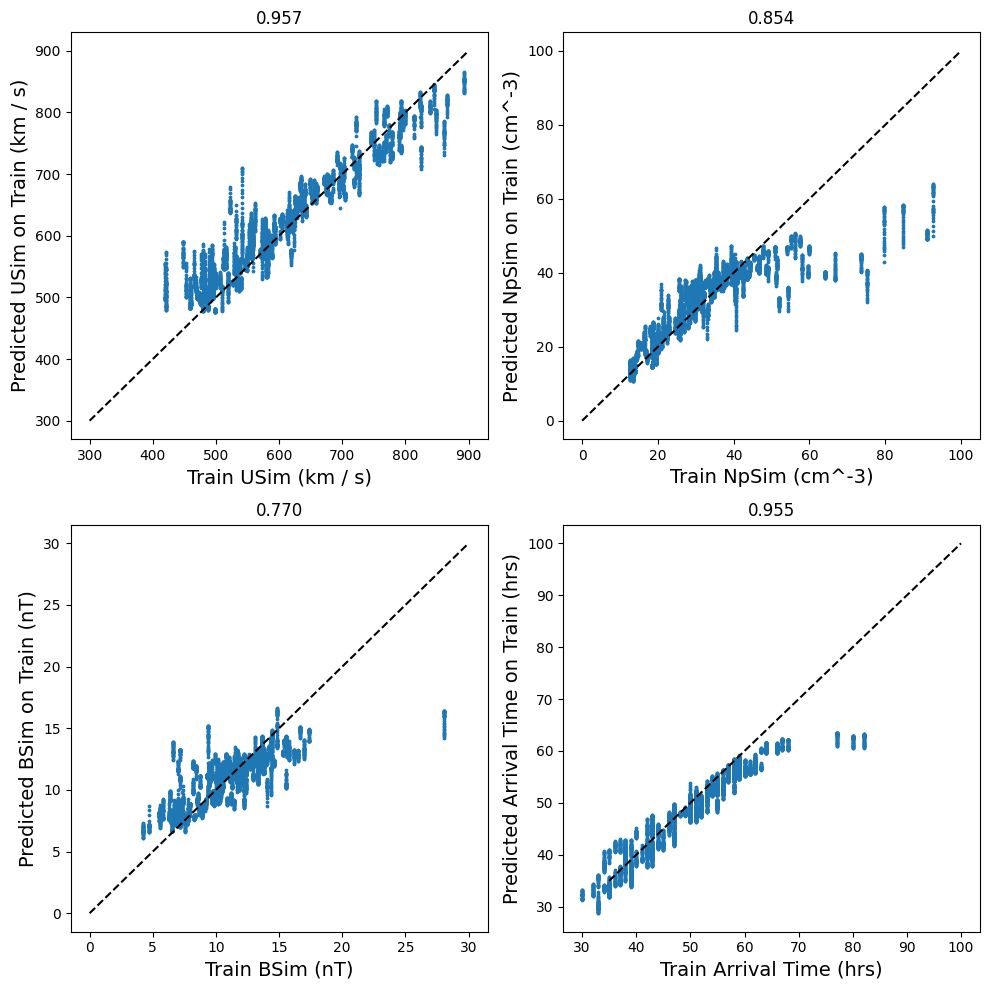

In [65]:
model.eval()
with torch.no_grad():
    train_preds_scaled = model(train_eval_batch[0]).cpu().numpy()

train_preds_unscaled = pt.inverse_transform(train_preds_scaled)
train_targets_all = train_eval_batch[2].squeeze(1).cpu().numpy()

train_preds_unscaled.shape, train_targets_all.shape

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[1, 1].scatter(train_targets_all[:, 3], train_preds_unscaled[:, 3], s=3)
axs[1, 1].plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--', color='black')
axs[1, 1].set_xlabel("Train Arrival Time (hrs)", fontsize=14)
axs[1, 1].set_ylabel("Predicted Arrival Time on Train (hrs)", fontsize=14)
axs[1, 1].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 3], train_preds_unscaled[:, 3])[0, 1]))

axs[0, 0].scatter(train_targets_all[:, 0], train_preds_unscaled[:, 0], s=3)
axs[0, 0].plot(np.linspace(300, 900, 40), np.linspace(300, 900, 40), '--', color='black')
axs[0, 0].set_xlabel("Train USim (km / s)", fontsize=14)
axs[0, 0].set_ylabel("Predicted USim on Train (km / s)", fontsize=14)
axs[0, 0].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 0], train_preds_unscaled[:, 0])[0, 1]))

axs[1, 0].scatter(train_targets_all[:, 2], train_preds_unscaled[:, 2], s=3)
axs[1, 0].plot(np.linspace(0, 30, 40), np.linspace(0, 30, 40), '--', color='black')
axs[1, 0].set_xlabel("Train BSim (nT)", fontsize=14)
axs[1, 0].set_ylabel("Predicted BSim on Train (nT)", fontsize=14)
axs[1, 0].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 2], train_preds_unscaled[:, 2])[0, 1]))

axs[0, 1].scatter(train_targets_all[:, 1], train_preds_unscaled[:, 1], s=3)
axs[0, 1].plot(np.linspace(0, 100, 40), np.linspace(0, 100, 40), '--', color='black')
axs[0, 1].set_xlabel("Train NpSim (cm^-3)", fontsize=14)
axs[0, 1].set_ylabel("Predicted NpSim on Train (cm^-3)", fontsize=14)
axs[0, 1].set_title("{:.3f}".format(np.corrcoef(train_targets_all[:, 1], train_preds_unscaled[:, 1])[0, 1]))

plt.tight_layout()

(1900, 4) (1900, 4)


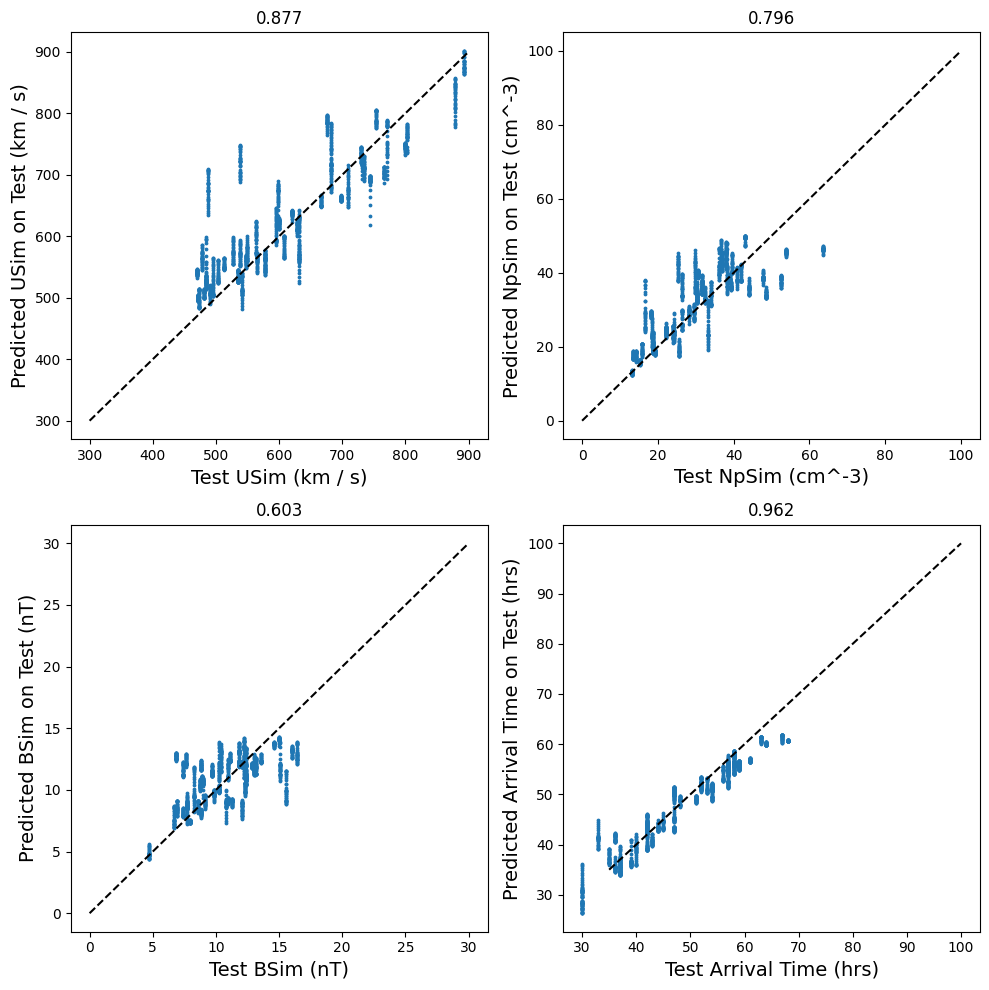

In [66]:
test_data_all = get_next_batch(inf_generator(test_dataloader))
# true_test_arrs = pt.inverse_transform(test_data_all[1].cpu().numpy())
true_test_arrs = test_data_all[2].squeeze(1).cpu().numpy()
model.eval()
with torch.no_grad():
    test_preds = model(test_data_all[0].to(device)).cpu().numpy()

test_preds_unscaled = pt.inverse_transform(test_preds)

print(test_preds_unscaled.shape, true_test_arrs.shape)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[1, 1].scatter(true_test_arrs[:, 3], test_preds_unscaled[:, 3], s=3)
axs[1, 1].plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--', color='black')
axs[1, 1].set_xlabel("Test Arrival Time (hrs)", fontsize=14)
axs[1, 1].set_ylabel("Predicted Arrival Time on Test (hrs)", fontsize=14)
axs[1, 1].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 3], test_preds_unscaled[:, 3])[0, 1]))

axs[0, 0].scatter(true_test_arrs[:, 0], test_preds_unscaled[:, 0], s=3)
axs[0, 0].plot(np.linspace(300, 900, 40), np.linspace(300, 900, 40), '--', color='black')
axs[0, 0].set_xlabel("Test USim (km / s)", fontsize=14)
axs[0, 0].set_ylabel("Predicted USim on Test (km / s)", fontsize=14)
axs[0, 0].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 0], test_preds_unscaled[:, 0])[0, 1]))

axs[1, 0].scatter(true_test_arrs[:, 2], test_preds_unscaled[:, 2], s=3)
axs[1, 0].plot(np.linspace(0, 30, 40), np.linspace(0, 30, 40), '--', color='black')
axs[1, 0].set_xlabel("Test BSim (nT)", fontsize=14)
axs[1, 0].set_ylabel("Predicted BSim on Test (nT)", fontsize=14)
axs[1, 0].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 2], test_preds_unscaled[:, 2])[0, 1]))

axs[0, 1].scatter(true_test_arrs[:, 1], test_preds_unscaled[:, 1], s=3)
axs[0, 1].plot(np.linspace(0, 100, 40), np.linspace(0, 100, 40), '--', color='black')
axs[0, 1].set_xlabel("Test NpSim (cm^-3)", fontsize=14)
axs[0, 1].set_ylabel("Predicted NpSim on Test (cm^-3)", fontsize=14)
axs[0, 1].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 1], test_preds_unscaled[:, 1])[0, 1]))

plt.tight_layout()

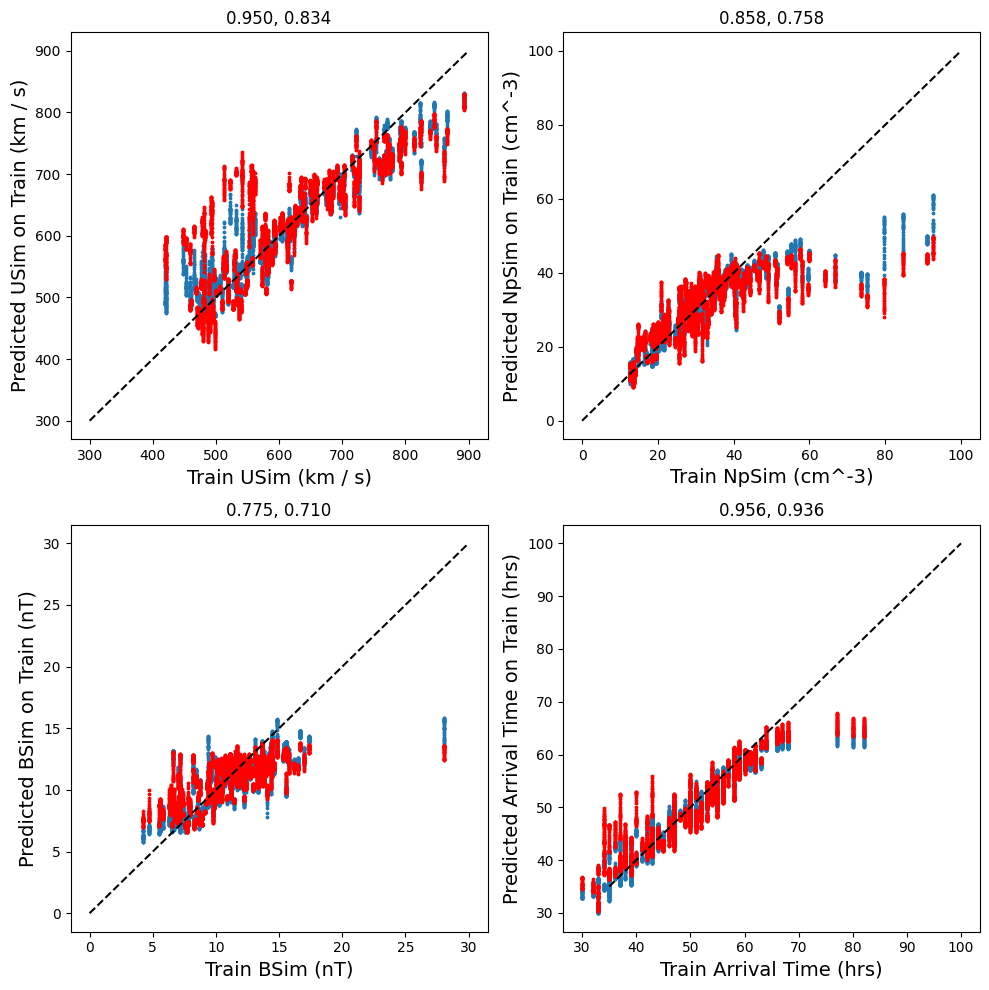

In [70]:
model.eval()
model2.eval()
with torch.no_grad():
    train_preds_scaled = model(train_eval_batch[0]).cpu().numpy()
    train_preds_scaled_aug = model2(train_eval_batch[0]).cpu().numpy()

train_preds_unscaled = pt.inverse_transform(train_preds_scaled)
train_preds_unscaled_aug = pt.inverse_transform(train_preds_scaled_aug)

train_targets_all = train_eval_batch[2].squeeze(1).cpu().numpy()

train_preds_unscaled.shape, train_targets_all.shape

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[1, 1].scatter(train_targets_all[:, 3], train_preds_unscaled[:, 3], s=3)
axs[1, 1].scatter(train_targets_all[:, 3], train_preds_unscaled_aug[:, 3], s=3, color='red')
axs[1, 1].plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--', color='black')
axs[1, 1].set_xlabel("Train Arrival Time (hrs)", fontsize=14)
axs[1, 1].set_ylabel("Predicted Arrival Time on Train (hrs)", fontsize=14)
axs[1, 1].set_title("{:.3f}, {:.3f}".format(np.corrcoef(train_targets_all[:, 3], train_preds_unscaled[:, 3])[0, 1],
                                            np.corrcoef(train_targets_all[:, 3], train_preds_unscaled_aug[:, 3])[0, 1]))

axs[0, 0].scatter(train_targets_all[:, 0], train_preds_unscaled[:, 0], s=3)
axs[0, 0].scatter(train_targets_all[:, 0], train_preds_unscaled_aug[:, 0], s=3, color='red')
axs[0, 0].plot(np.linspace(300, 900, 40), np.linspace(300, 900, 40), '--', color='black')
axs[0, 0].set_xlabel("Train USim (km / s)", fontsize=14)
axs[0, 0].set_ylabel("Predicted USim on Train (km / s)", fontsize=14)
axs[0, 0].set_title("{:.3f}, {:.3f}".format(np.corrcoef(train_targets_all[:, 0], train_preds_unscaled[:, 0])[0, 1],
                                            np.corrcoef(train_targets_all[:, 0], train_preds_unscaled_aug[:, 0])[0, 1]))

axs[1, 0].scatter(train_targets_all[:, 2], train_preds_unscaled[:, 2], s=3)
axs[1, 0].scatter(train_targets_all[:, 2], train_preds_unscaled_aug[:, 2], s=3, color='red')
axs[1, 0].plot(np.linspace(0, 30, 40), np.linspace(0, 30, 40), '--', color='black')
axs[1, 0].set_xlabel("Train BSim (nT)", fontsize=14)
axs[1, 0].set_ylabel("Predicted BSim on Train (nT)", fontsize=14)
axs[1, 0].set_title("{:.3f}, {:.3f}".format(np.corrcoef(train_targets_all[:, 2], train_preds_unscaled[:, 2])[0, 1],
                                            np.corrcoef(train_targets_all[:, 2], train_preds_unscaled_aug[:, 2])[0, 1]))

axs[0, 1].scatter(train_targets_all[:, 1], train_preds_unscaled[:, 1], s=3)
axs[0, 1].scatter(train_targets_all[:, 1], train_preds_unscaled_aug[:, 1], s=3, color='red')
axs[0, 1].plot(np.linspace(0, 100, 40), np.linspace(0, 100, 40), '--', color='black')
axs[0, 1].set_xlabel("Train NpSim (cm^-3)", fontsize=14)
axs[0, 1].set_ylabel("Predicted NpSim on Train (cm^-3)", fontsize=14)
axs[0, 1].set_title("{:.3f}, {:.3f}".format(np.corrcoef(train_targets_all[:, 1], train_preds_unscaled[:, 1])[0, 1],
                                            np.corrcoef(train_targets_all[:, 1], train_preds_unscaled_aug[:, 1])[0, 1]))

plt.tight_layout()

(1900, 4) (1900, 4)


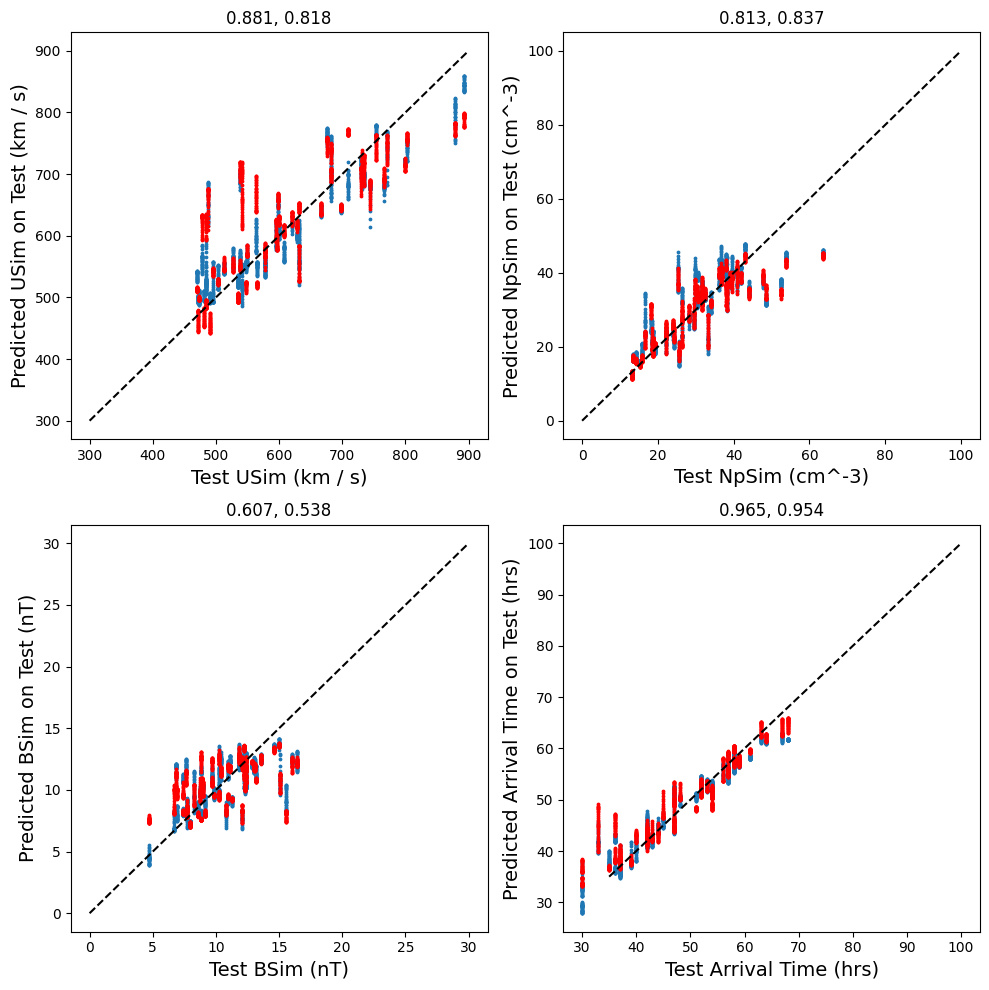

In [71]:
test_data_all = get_next_batch(inf_generator(test_dataloader))
true_test_arrs = test_data_all[2].squeeze(1).cpu().numpy()
model.eval()
model2.eval()
with torch.no_grad():
    test_preds = model(test_data_all[0].to(device)).cpu().numpy()
    test_preds_aug = model2(test_data_all[0].to(device)).cpu().numpy()
test_preds_unscaled = pt.inverse_transform(test_preds)
test_preds_unscaled_aug = pt.inverse_transform(test_preds_aug)

print(test_preds_unscaled.shape, true_test_arrs.shape)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[1, 1].scatter(true_test_arrs[:, 3], test_preds_unscaled[:, 3], s=3)
axs[1, 1].scatter(true_test_arrs[:, 3], test_preds_unscaled_aug[:, 3], s=3, color='red')
axs[1, 1].plot(np.linspace(35, 100, 40), np.linspace(35, 100, 40), '--', color='black')
axs[1, 1].set_xlabel("Test Arrival Time (hrs)", fontsize=14)
axs[1, 1].set_ylabel("Predicted Arrival Time on Test (hrs)", fontsize=14)
axs[1, 1].set_title("{:.3f}, {:.3f}".format(np.corrcoef(true_test_arrs[:, 3], test_preds_unscaled[:, 3])[0, 1],
                                            np.corrcoef(true_test_arrs[:, 3], test_preds_unscaled_aug[:, 3])[0, 1]))

axs[0, 0].scatter(true_test_arrs[:, 0], test_preds_unscaled[:, 0], s=3)
axs[0, 0].scatter(true_test_arrs[:, 0], test_preds_unscaled_aug[:, 0], s=3, color='red')
axs[0, 0].plot(np.linspace(300, 900, 40), np.linspace(300, 900, 40), '--', color='black')
axs[0, 0].set_xlabel("Test USim (km / s)", fontsize=14)
axs[0, 0].set_ylabel("Predicted USim on Test (km / s)", fontsize=14)
axs[0, 0].set_title("{:.3f}, {:.3f}".format(np.corrcoef(true_test_arrs[:, 0], test_preds_unscaled[:, 0])[0, 1],
                                            np.corrcoef(true_test_arrs[:, 0], test_preds_unscaled_aug[:, 0])[0, 1]))

axs[1, 0].scatter(true_test_arrs[:, 2], test_preds_unscaled[:, 2], s=3)
axs[1, 0].scatter(true_test_arrs[:, 2], test_preds_unscaled_aug[:, 2], s=3, color='red')
axs[1, 0].plot(np.linspace(0, 30, 40), np.linspace(0, 30, 40), '--', color='black')
axs[1, 0].set_xlabel("Test BSim (nT)", fontsize=14)
axs[1, 0].set_ylabel("Predicted BSim on Test (nT)", fontsize=14)
axs[1, 0].set_title("{:.3f}, {:.3f}".format(np.corrcoef(true_test_arrs[:, 2], test_preds_unscaled[:, 2])[0, 1],
                                            np.corrcoef(true_test_arrs[:, 2], test_preds_unscaled_aug[:, 2])[0, 1]))

axs[0, 1].scatter(true_test_arrs[:, 1], test_preds_unscaled[:, 1], s=3)
axs[0, 1].scatter(true_test_arrs[:, 1], test_preds_unscaled_aug[:, 1], s=3, color='red')
axs[0, 1].plot(np.linspace(0, 100, 40), np.linspace(0, 100, 40), '--', color='black')
axs[0, 1].set_xlabel("Test NpSim (cm^-3)", fontsize=14)
axs[0, 1].set_ylabel("Predicted NpSim on Test (cm^-3)", fontsize=14)
axs[0, 1].set_title("{:.3f}".format(np.corrcoef(true_test_arrs[:, 1], test_preds_unscaled[:, 1])[0, 1]))
axs[0, 1].set_title("{:.3f}, {:.3f}".format(np.corrcoef(true_test_arrs[:, 1], test_preds_unscaled[:, 1])[0, 1],
                                            np.corrcoef(true_test_arrs[:, 1], test_preds_unscaled_aug[:, 1])[0, 1]))

plt.tight_layout()